In [18]:
from pathlib import Path
from rodent_loss_src.rnaseq import read_oma, parse_rnaseq, find_significant
import pandas as pd

ORGANISMS = ["human", "mouse"]
MIRNAS = ["mir197", "mir769"]
PROJECTDIR = Path('.').resolve().parents[2]
oma_path = f'{PROJECTDIR}/external_data/human_mouse_omapairwise.txt'
target_path = f'{PROJECTDIR}/milestones/data/targetscan/unweighted_TargetScanHuman_human_mouse_mir197_mir769.tsv'
# output
overlap_path = f'{PROJECTDIR}/publication/supplement_tables/targets_overlap_log2fold025.tsv'


def split_up_down_regulated(df):
    """
    """
    df['gene'] = df['gene'].str.upper()
    up = df[df['log2FoldChange'] >= 0].reset_index(drop=True)
    down = df[df['log2FoldChange'] <= -0].reset_index(drop=True)
    return list(up.gene.values), list(down.gene.values)


def filter_targets_for_condition(df, organism, mirna, context_score_cutoff):
    df = df[
        (df.organism == organism) & (df.mirna == mirna)
    ]
    fdf = df.copy().drop(columns=['organism', 'mirna'])
    fdf = fdf.rename(columns={'target_gene': 'gene', 'Total context++ score': 'TShuman_tc++s'})
    fdf = fdf[fdf['TShuman_tc++s'] <= context_score_cutoff]
    if organism == 'mouse':
        fdf.gene = fdf.gene.str.capitalize()
    return fdf


def list_to_capitalized_and_capital_set(l):
    capitalized = {gene.capitalize() for gene in l}
    capital = {gene.upper() for gene in l}
    return capitalized.union(capital)


def find_down_and_predicted(predicted_targets, pairwise, min_reads, min_adj_p, min_logfoldchange, context_score_cutoff):
    col = {}
    for organism in ORGANISMS:
        for mirna in MIRNAS:
            condition = f'{organism}|{mirna}'
            in_path = f"{PROJECTDIR}/analyses/rnaseq/data/{organism}_results_Neg_vs_{mirna}.tsv"
            rnadf = parse_rnaseq(in_path, pairwise, organism, mirna)
            differential = find_significant(rnadf, min_reads, min_adj_p, min_logfoldchange)
            up, down = split_up_down_regulated(differential)
            condition_specific_targets = filter_targets_for_condition(predicted_targets, organism, mirna, context_score_cutoff)
            # find down and predicted
            #display(condition_specific_targets)
            # display(down)
            down = list_to_capitalized_and_capital_set(down)
            condition_specific_targets = list_to_capitalized_and_capital_set(condition_specific_targets.gene.values)
            doapr = condition_specific_targets.intersection(down)
            # display(condition_specific_targets)
            human_dopar = {gene.upper() for gene in doapr}
            col[condition] = human_dopar
    return col


def print_overlaps(d):
    skip = set()
    col = []
    for condition1 in d:
        for condition2 in d:
            if f'{condition1}|{condition2}' in skip:
                continue
            if condition1 == condition2:
                continue
            overlap = d[condition1].intersection(d[condition2])
            display(f'{condition1} - {condition2}: {len(overlap)}, {overlap}')
            skip.add(f'{condition2}|{condition1}')
            col.append([condition1, condition2, overlap, len(overlap)])
    df = pd.DataFrame(col, columns=['condition1', 'condition2', 'overlap', 'num_overlap'])
    return df




In [19]:
min_reads = 100
min_adj_p = 0.05
min_logfoldchange = 0.25
context_score_cutoff = -0.2

# load OMA pairwise orthologs
pairwise = read_oma(oma_path)
assert len(pairwise) > 0

# load predicted targets
predicted_targets = pd.read_csv(target_path, sep='\t')
down_and_predicted = find_down_and_predicted(predicted_targets, pairwise, min_reads, min_adj_p, min_logfoldchange, context_score_cutoff)
overlap = print_overlaps(down_and_predicted)

No. unique human orthologs: 18105
No. unique mouse orthologs: 18205


"human|mir197 - human|mir769: 1, {'HTR7'}"

"human|mir197 - mouse|mir197: 11, {'CCDC85C', 'ARMC1', 'RAB28', 'TNFRSF21', 'ATP6V1A', 'MPZL1', 'TRIT1', 'AMMECR1L', 'KPNA6', 'MAPK8', 'TTPAL'}"

"human|mir197 - mouse|mir769: 2, {'MBD1', 'ERLIN2'}"

"human|mir769 - mouse|mir197: 2, {'STK35', 'TFAM'}"

"human|mir769 - mouse|mir769: 3, {'WDR37', 'FAM117B', 'TFAM'}"

"mouse|mir197 - mouse|mir769: 3, {'SMYD5', 'SLX4IP', 'TFAM'}"

## Plot

,condition1,condition2,overlap,num_overlap,label
0,human|mir197,human|mir769,{HTR7},1,human|mir197 - human|mir769
1,human|mir197,mouse|mir197,"{CCDC85C, ARMC1, RAB28, TNFRSF21, ATP6V1A, MPZ...",11,human|mir197 - mouse|mir197
2,human|mir197,mouse|mir769,"{MBD1, ERLIN2}",2,human|mir197 - mouse|mir769
3,human|mir769,mouse|mir197,"{STK35, TFAM}",2,human|mir769 - mouse|mir197
4,human|mir769,mouse|mir769,"{WDR37, FAM117B, TFAM}",3,human|mir769 - mouse|mir769
5,mouse|mir197,mouse|mir769,"{SMYD5, SLX4IP, TFAM}",3,mouse|mir197 - mouse|mir769


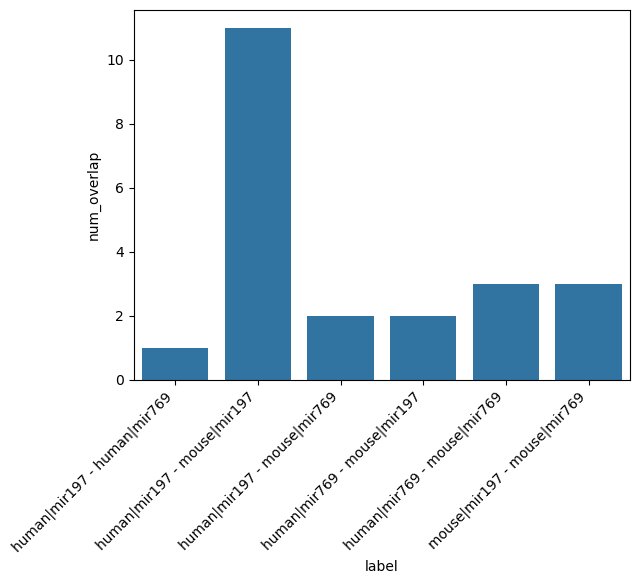

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt


overlap['label'] = overlap.condition1 + ' - ' + overlap.condition2
display(overlap)

sns.barplot(data=overlap, x='label', y='num_overlap')
plt.xticks(rotation=45, ha='right')
plt.show()

## Export

In [21]:
overlap.to_csv(overlap_path, sep='\t', index=False)